In [15]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DistilBertConfig
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
import random
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.nn import CrossEntropyLoss
import nltk

In [16]:
df = pd.read_csv("dataset/combined_GH_HF_manual.csv")

# Function to clean text columns
def clean_text(text):
    # Remove non-ASCII characters (corrupted/malformed characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    return text.strip()

# Apply cleaning function to relevant columns
df['message'] = df['message'].apply(clean_text)
df = df[df['message'].notna() & (df['message'] != '') & (df['message'].str.split().str.len() > 1)]
df["label"] = df["label"].str.lower()

number_of_labels = df["label"].value_counts()
number_of_labels

label
external documentation       501
model structure              195
project metadata             141
sharing                      127
preprocessing                 61
training infrastructure       55
validation infrastructure     52
input data                    35
internal documentation        35
pipeline performance          33
parameter tuning              31
add dependency                19
output data                   18
update dependency             17
remove dependency             15
Name: count, dtype: int64

In [3]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label"]), 
    y=df["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Check class weights
print("Class Weights:", class_weights)


Class Weights: tensor([4.6842, 0.1776, 2.5429, 2.5429, 0.4564, 4.9444, 2.8710, 2.6970, 1.4590,
        0.6312, 5.9333, 0.7008, 1.6182, 5.2353, 1.7115])


In [ ]:
"""nltk.download('wordnet')
nltk.download('omw-1.4')

def augment_text(text):
    words = text.split()
    new_words = []
    
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms and random.random() < 0.3:  # 30% chance to replace a word
            new_word = synonyms[0].lemmas()[0].name()
            new_words.append(new_word)
        else:
            new_words.append(word)
    
    return " ".join(new_words)

# Apply to underrepresented labels
rare_labels = ["add dependency", "output data", "update dependency", "remove dependency"]
augmented_data = df[df["label"].isin(rare_labels)].copy()
augmented_data["message"] = augmented_data["message"].apply(augment_text)

# Duplicate & add to original dataset
df = pd.concat([df, augmented_data], ignore_index=True)




tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["message"]).toarray()
y = df["label"]

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Convert back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=tfidf.get_feature_names_out())
df_resampled["label"] = y_resampled

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label"]), 
    y=df["label"]
)
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


loss_fn = CrossEntropyLoss(weight=class_weights)
"""

In [ ]:
"""from collections import Counter

# Check label distribution
label_counts = Counter(df_resampled["label"])
label_counts"""

In [ ]:
"""label_encoder = LabelEncoder()

# Fit & transform labels to numeric values
df["label"] = label_encoder.fit_transform(df["label"])


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(lambda e: {'label': int(e['label'])})
test_dataset = test_dataset.map(lambda e: {'label': int(e['label'])})"""

In [ ]:
"""train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(lambda e: {'label': int(e['label'])})
test_dataset = test_dataset.map(lambda e: {'label': int(e['label'])})"""


In [4]:
# First, split into training (80%) and testing (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Then, split the training set into training (80% of 80% = 64%) and validation (20% of 80% = 16%)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Ensure labels are of type integer
train_dataset = train_dataset.map(lambda e: {'label': int(e['label'])})
val_dataset = val_dataset.map(lambda e: {'label': int(e['label'])})
test_dataset = test_dataset.map(lambda e: {'label': int(e['label'])})

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Training samples: 854, Validation samples: 214, Test samples: 267


In [5]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["message"], padding="max_length", truncation=True)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

In [6]:
class DistilBERTWithWeightedLoss(nn.Module):
    def __init__(self, model_name, num_labels, class_weights, dropout=0.4):
        super().__init__()
        
        # Create a custom configuration with modified dropout
        config = DistilBertConfig.from_pretrained(
            model_name, 
            num_labels=num_labels, 
            hidden_dropout_prob=dropout,  # Dropout for feedforward layers
            attention_probs_dropout_prob=dropout  # Dropout for attention layers
        )

        # Load the model with the custom config
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [7]:
device = torch.device("mps" if torch.has_mps else "cpu")
print(f"Using device: {device}")

# Initialize model
num_labels = len(label_encoder.classes_)  # Count unique labels
model = DistilBERTWithWeightedLoss(model_name, num_labels, class_weights, dropout=0.2)
model.to(device)



# Initialize model
num_labels = len(label_encoder.classes_)  # Count unique labels
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBERTWithWeightedLoss(model_name, num_labels, class_weights, dropout=0.4)
model.to(device)  # Move model to GPU if available

/var/folders/4p/p4dff74s5rb42f27sxjfg97r0000gn/T/ipykernel_18979/763989385.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERTWithWeightedLoss(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
"""# Initialize model
num_labels = len(label_encoder.classes_)  # Count unique labels
model = DistilBERTWithWeightedLoss(model_name, num_labels, class_weights, dropout=0.2)
model.to(device)

# Initialize model
num_labels = len(label_encoder.classes_)  # Count unique labels
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBERTWithWeightedLoss(model_name, num_labels, class_weights, dropout=0.4)
model.to(device)  # Move model to GPU if available"""

In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,  # Keep only the best model
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Lower loss is better
    learning_rate= 1e-5,  # Lower learning rate to improve stability
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,  # Reduce epochs to prevent overfitting
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_steps=1000,  # Log less frequently to reduce clutter
    report_to="none",  # Prevents reporting to WandB, TensorBoard, etc.
    fp16=False,  # Disable mixed precision to avoid MPS issue
    warmup_ratio=0.1,  # Warm-up for the first 10% of training
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,  # Helps stabilize training
)

/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [10]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.685000,2.666172,0.408240,0.664153,0.408240,0.288980
2,2.600600,2.560754,0.475655,0.586923,0.475655,0.447999
3,2.473400,2.473423,0.468165,0.624981,0.468165,0.460863
4,2.352000,2.408517,0.513109,0.623122,0.513109,0.505449


TrainOutput(global_step=265, training_loss=2.4987273594118515, metrics={'train_runtime': 788.5153, 'train_samples_per_second': 5.415, 'train_steps_per_second': 0.336, 'total_flos': 0.0, 'train_loss': 2.4987273594118515, 'epoch': 4.91588785046729})

In [12]:
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

trainer.save_model("./final_model")
tokenizer.save_pretrained("./final_model")
config.save_pretrained("./final_model")

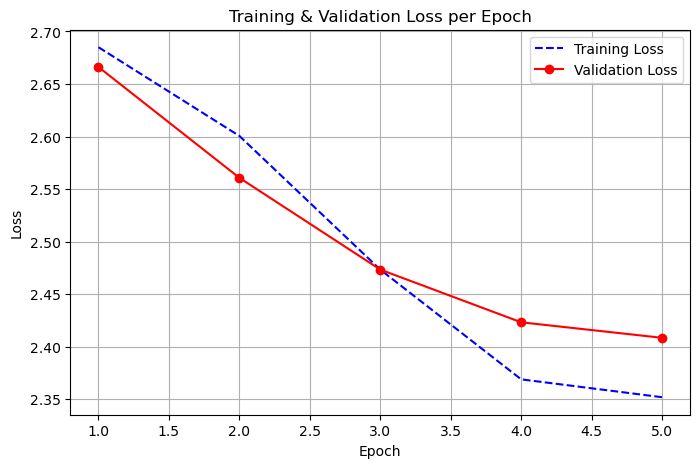

In [11]:
train_loss = []
eval_loss = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        epochs.append(len(eval_loss))  # Count only validation loss steps

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", color="blue", linestyle="--")
plt.plot(epochs, eval_loss, label="Validation Loss", color="red", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

In [13]:
from transformers import AutoTokenizer, DistilBertForSequenceClassification

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("./final_model")

# Load the model
model = DistilBertForSequenceClassification.from_pretrained("./final_model", local_files_only=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./final_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0

In [14]:
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("./final_model")
model = DistilBertForSequenceClassification.from_pretrained("./final_model", local_files_only=True)

# Move the model to the appropriate device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Prepare the test data
test_texts = test_df['message'].tolist()
test_labels = test_df['label'].tolist()

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")

# Make predictions
model.eval()
with torch.no_grad():
    test_encodings = {k: v.to(device) for k, v in test_encodings.items()}
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Evaluate the results
print(classification_report(test_labels, predictions, target_names=label_encoder.classes_))

# If you want to see predictions for individual examples:
for text, true_label, pred_label in zip(test_texts[:10], test_labels[:10], predictions[:10]):
    print(f"Text: {text[:50]}...")
    print(f"True label: {label_encoder.inverse_transform([true_label])[0]}")
    print(f"Predicted label: {label_encoder.inverse_transform([pred_label])[0]}")
    print("---")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./final_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0

                           precision    recall  f1-score   support

           add dependency       0.00      0.00      0.00         4
   external documentation       0.00      0.00      0.00       100
               input data       0.00      0.00      0.00         7
   internal documentation       0.00      0.00      0.00         7
          model structure       0.00      0.00      0.00        39
              output data       0.00      0.00      0.00         4
         parameter tuning       0.00      0.00      0.00         6
     pipeline performance       0.00      0.00      0.00         7
            preprocessing       0.00      0.00      0.00        12
         project metadata       0.10      1.00      0.19        28
        remove dependency       0.00      0.00      0.00         3
                  sharing       0.00      0.00      0.00        25
  training infrastructure       0.00      0.00      0.00        11
        update dependency       0.00      0.00      0.00     

/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [2]:
df = pd.read_csv("dataset/combined_GH_HF_manual.csv")

# Function to clean text columns
def clean_text(text):
    # Remove non-ASCII characters (corrupted/malformed characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    return text.strip()

# Apply cleaning function to relevant columns
df['message'] = df['message'].apply(clean_text)
df = df[df['message'].notna() & (df['message'] != '') & (df['message'].str.split().str.len() > 1)]
df["label"] = df["label"].str.lower()

number_of_labels = df["label"].value_counts()
number_of_labels

label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['label'])  # Encode the labels as integers

# Now split the dataset
data_texts = df['message'].tolist()  # Your text data
data_labels = df['encoded_labels'].tolist()  # Your encoded integer labels

# Split into Train and Validation (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# Further split Train data into Train and Test (99% train, 1% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

# Check the number of items in each split
print(f"Training data: {len(train_texts)}")
print(f"Validation data: {len(val_texts)}")
print(f"Test data: {len(test_texts)}")

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Preprocessing function to tokenize the data
def preprocess_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, return_tensors="pt")

# Tokenize the train, validation, and test data
train_encodings = preprocess_function(train_texts)
val_encodings = preprocess_function(val_texts)
test_encodings = preprocess_function(test_texts)

# Check the lengths of the encoded data
print(len(train_encodings["input_ids"]))  # Should match len(train_texts)
print(len(val_encodings["input_ids"]))    # Should match len(val_texts)
print(len(test_encodings["input_ids"]))   # Should match len(test_texts)

# Now create the datasets with integer labels
train_dataset = [{
    "input_ids": enc, 
    "attention_mask": train_encodings["attention_mask"][i], 
    "labels": torch.tensor(train_labels[i])  # Ensure labels are a tensor (integers)
} for i, enc in enumerate(train_encodings["input_ids"])]

val_dataset = [{
    "input_ids": enc, 
    "attention_mask": val_encodings["attention_mask"][i], 
    "labels": torch.tensor(val_labels[i])  # Ensure labels are a tensor (integers)
} for i, enc in enumerate(val_encodings["input_ids"])]

test_dataset = [{
    "input_ids": enc, 
    "attention_mask": test_encodings["attention_mask"][i], 
    "labels": torch.tensor(test_labels[i])  # Ensure labels are a tensor (integers)
} for i, enc in enumerate(test_encodings["input_ids"])]

# Check the first tokenized data example from the train dataset
print(train_dataset[0])

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 2e-5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 0.1)  # Now tuning weight decay

    # Reinitialize model for each trial to avoid contamination
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=15)

    # Set training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,  # Ensure eval batch size matches
        num_train_epochs=7,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="epoch",  # Save best model per epoch
        load_best_model_at_end=True,  # Load the best model automatically
        metric_for_best_model="eval_loss",
        greater_is_better=False,  # We want lower validation loss
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Stop if no improvement in 2 epochs
    )

    # Train and return validation loss
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results['eval_loss']

# Optimize the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2)

# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Define the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=15)

# Set up training arguments with best hyperparameters
training_args = TrainingArguments(
    output_dir="./results",            
    evaluation_strategy="epoch",       
    learning_rate=1.6197048683804554e-05,  # Optuna's best learning rate
    per_device_train_batch_size=8,       # Optuna's best batch size
    num_train_epochs=10,                  
    weight_decay=0.020932077220795306,    # Optuna's best weight decay
    logging_dir="./logs",                
    logging_steps=10                     
)

# Subclass Trainer to remove weighted loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # Accept arbitrary keyword arguments
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Use standard CrossEntropyLoss without weights
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

    
# Instantiate the custom trainer without class weights
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

NameError: name 'pd' is not defined